In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
from transformers import GPT2TokenizerFast, GPT2LMHeadModel, AutoTokenizer, BertForMaskedLM
from torch.nn.functional import softmax
from difflib import SequenceMatcher
from spellchecker import SpellChecker
from string import punctuation
from time import time
import nltk

In [2]:
class GPT2:
    def __init__(self, model="gpt2"):
        self.model     =   GPT2LMHeadModel.from_pretrained(model)
        self.tokenizer = GPT2TokenizerFast.from_pretrained(model)
        self.model_id  = model
    
    def get_word_probs(self, sentence, n=5000):  # adapted from raul on stackoverflow
        inputs = self.tokenizer.encode(sentence, return_tensors="pt")
        with torch.no_grad():
            outputs = self.model(inputs)
            predictions = outputs[0]
        candidates = predictions[0, -1, :]                          # Get the next token candidates.
        topk_i = torch.topk(candidates, n).indices.tolist()         # Get the top k next token candidates.
        all_probs = torch.nn.functional.softmax(candidates, dim=-1) # Get the token probabilities for all candidates.
        topk_probs = all_probs[topk_i].tolist()                     # Filter the token probabilities for the top k candidates.
        topk_tokens = [self.tokenizer.decode([idx]).strip()         # Decode the top k candidates back to words.
                       for idx in topk_i]
        return list(zip(topk_tokens, topk_probs))

class BERT:
    def __init__(self, model="google-bert/bert-base-uncased"):
        self.model     = BertForMaskedLM.from_pretrained(model)
        self.tokenizer =   AutoTokenizer.from_pretrained(model)
        self.model_id  = model
    def get_word_probs(self, prompt, topk=5000):                  # Get topk masked token candidates
        inputs = self.tokenizer(prompt, return_tensors="pt")
        with torch.no_grad():
            logits = self.model(**inputs).logits
        mask_index  = (inputs.input_ids == self.tokenizer.mask_token_id)[0].nonzero(as_tuple=True)[0]
        mask_logits = logits.squeeze()[mask_index].squeeze()
        probs = softmax(mask_logits, dim=-1)
        topk = 5000
        topk_probs, topk_i = torch.topk(probs, topk, dim=-1)
        topk_tokens = np.array([self.tokenizer.decode([i]) for i in topk_i])
        return np.hstack((topk_tokens.reshape(-1,1), np.array(topk_probs).reshape(-1,1)))

In [3]:
pd.options.display.float_format = '{:.6f}'.format
nltk.download('words')
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()
def rreplace(string, word, new_word):
    start = string.rfind(word)
    return string[0:start] + new_word + string[start+len(word):]
wl          = set(nltk.corpus.words.words())
log_map     = lambda e: np.vectorize(lambda x: np.power(np.log(x/0.5)/np.log(2), e))  # specify exponent to return vectorized mapping
after_slash = lambda x: x[(x.rfind("/")+1 if x.rfind("/") != -1 else 0):]
M_GPT2      = GPT2("gpt2")
M_BERT      = BERT("google-bert/bert-base-uncased")

[nltk_data] Downloading package words to C:\Users\bills-fish-
[nltk_data]     shack\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


In [4]:
def get_data(strings, back_n, print_times=False):
    places = [range(1,back_n+1)] * len(strings)
    data   = []
    times  = []
    if print_times: print('model run times: ', end='')
    for string, places in zip(strings, places):
        t0     = time()
        case   = []
        words  = string.split()
        for n in places:
            if n > len(words): 
                break
            if n > 1:
                model  = M_BERT
                masked = "[MASK]" + words[-n][-1] if not words[-n][-1].isalpha() else "[MASK]"
                target = words[-n].strip(punctuation)
                prompt = ' '.join(words[:-n] + [masked] + words[len(words)-(n-1):])
            else:
                model  = M_GPT2
                string = string.strip()
                last_space = string.rfind(' ')
                prompt = string[:last_space]
                target = string[last_space+1:].strip(punctuation)
                
            probs  = model.get_word_probs(prompt)                
            probsp = [(word, float(prob), float(similar(target, word))) for word, prob in probs if word in wl]
            close_probs = [prob for prob in probsp if prob[2] > 0.5 and prob[1] >= min(0.001, probsp[consider_top][1])]
            close_adj = pd.DataFrame([(word, sim, prob, (prob**prob_exp)*log_map(log_exp)(sim)) 
                                      for word, prob, sim in close_probs],
                                     columns=["word", "similarity", "probability", "log-map prob",])
            props = close_adj[["word", "similarity", "log-map prob"]].sort_values("log-map prob", ascending=False)
            props = props[props["log-map prob"] > 0.000001]
            case.append([(prompt, target, after_slash(model.model_id)), probsp, props])
        times.append(time()-t0)
        data.append(case)
        if print_times: print(f"{round(times[-1], 2)} ", end="")
    if print_times:     print(f"\naverage: {round(np.mean(times), 2)} seconds")
    return data

In [5]:
def plot_data(data):
    for case in data:
        fig, (axes) = plt.subplots(len(case), 2, figsize=(15,4*len(case)), width_ratios=(3.5,1))
        n = 1
        for ((prompt, target, model), probsp, props), (ax) in zip(case, axes.reshape(-1, 2)):
            topN = 60
            prompt = prompt.replace("\n", " ")
            probs_plot = np.array(probsp[:topN])
            cmap = mpl.colormaps['Blues']
            norm = mpl.colors.Normalize(vmin=0.18, vmax=1.0)
            ax[0].bar(probs_plot[:,0], probs_plot[:,1].astype(float), width=0.75, edgecolor='gray',
                    color=cmap(norm(probs_plot[:,2].astype(float))))
            ax[0].set_xlim(-1,topN)
            ax[0].set_xticks(range(len(probs_plot[:,0])), probs_plot[:,0], rotation=90, fontsize=10)
            ex_len = {"gpt2": 100, "bert": 70}[model[:4]]
            ax[0].set_ylabel('probability')
            probN = threshold(n)
            propsp = props[["word", "log-map prob"]].values[:10]
            if len(propsp) == 0:
                propsp = np.array([['', 0]])
            for bar, sim in zip(ax[1].bar(propsp[:,0], propsp[:,1], width=.8), 
                                props["similarity"].values):
                height = bar.get_height()
                ax[1].text(bar.get_x()+0.4, bar.get_height()+(max(propsp[0,1], probN)*0.01), 
                           round(sim, 2), horizontalalignment='center')
            ax[1].set_xticks(range(len(propsp[:,0])), propsp[:,0], rotation=45)
            ax[1].set_ylim([0, max(float(propsp[0,1])*1.15, probN*1.18)])
            ax[1].axhline(y=probN, color='r', label=f'correction threshold ({probN:.4f})')
            make_correction = False
            if isinstance(propsp[0][1], float) and propsp[0][1] > probN:
                irr_t = propsp[0][1] * relevency_t
                make_correction = True
                for i, score in enumerate(propsp[:,1]): 
                    if score < irr_t:
                        ax[1].axvline(x=i-0.5, color='g', label=f'relevency threshold ({relevency_t:.2f})')
                        break
                    elif target.lower() == props.iloc[i]["word"].lower():
                        make_correction = False
            ax[0].set_title(f'model={model[:4]}, prompt:target  |  "{prompt if len(prompt) < ex_len else f"...{prompt[-ex_len:]}"}'
                  f'":"{target}"  |  make_correction={make_correction}', fontsize=10)
            ax[1].set_title('correction proposals (similarity overlay)', fontsize=10)
            ax[1].set_ylabel(f'log-map prob (exponent: {log_exp:.1f})')
            ax[1].legend(fontsize=7)
            n += 1
        plt.tight_layout()
        plt.show()

model run times: 0.47 0.3 0.28 
average: 0.35 seconds


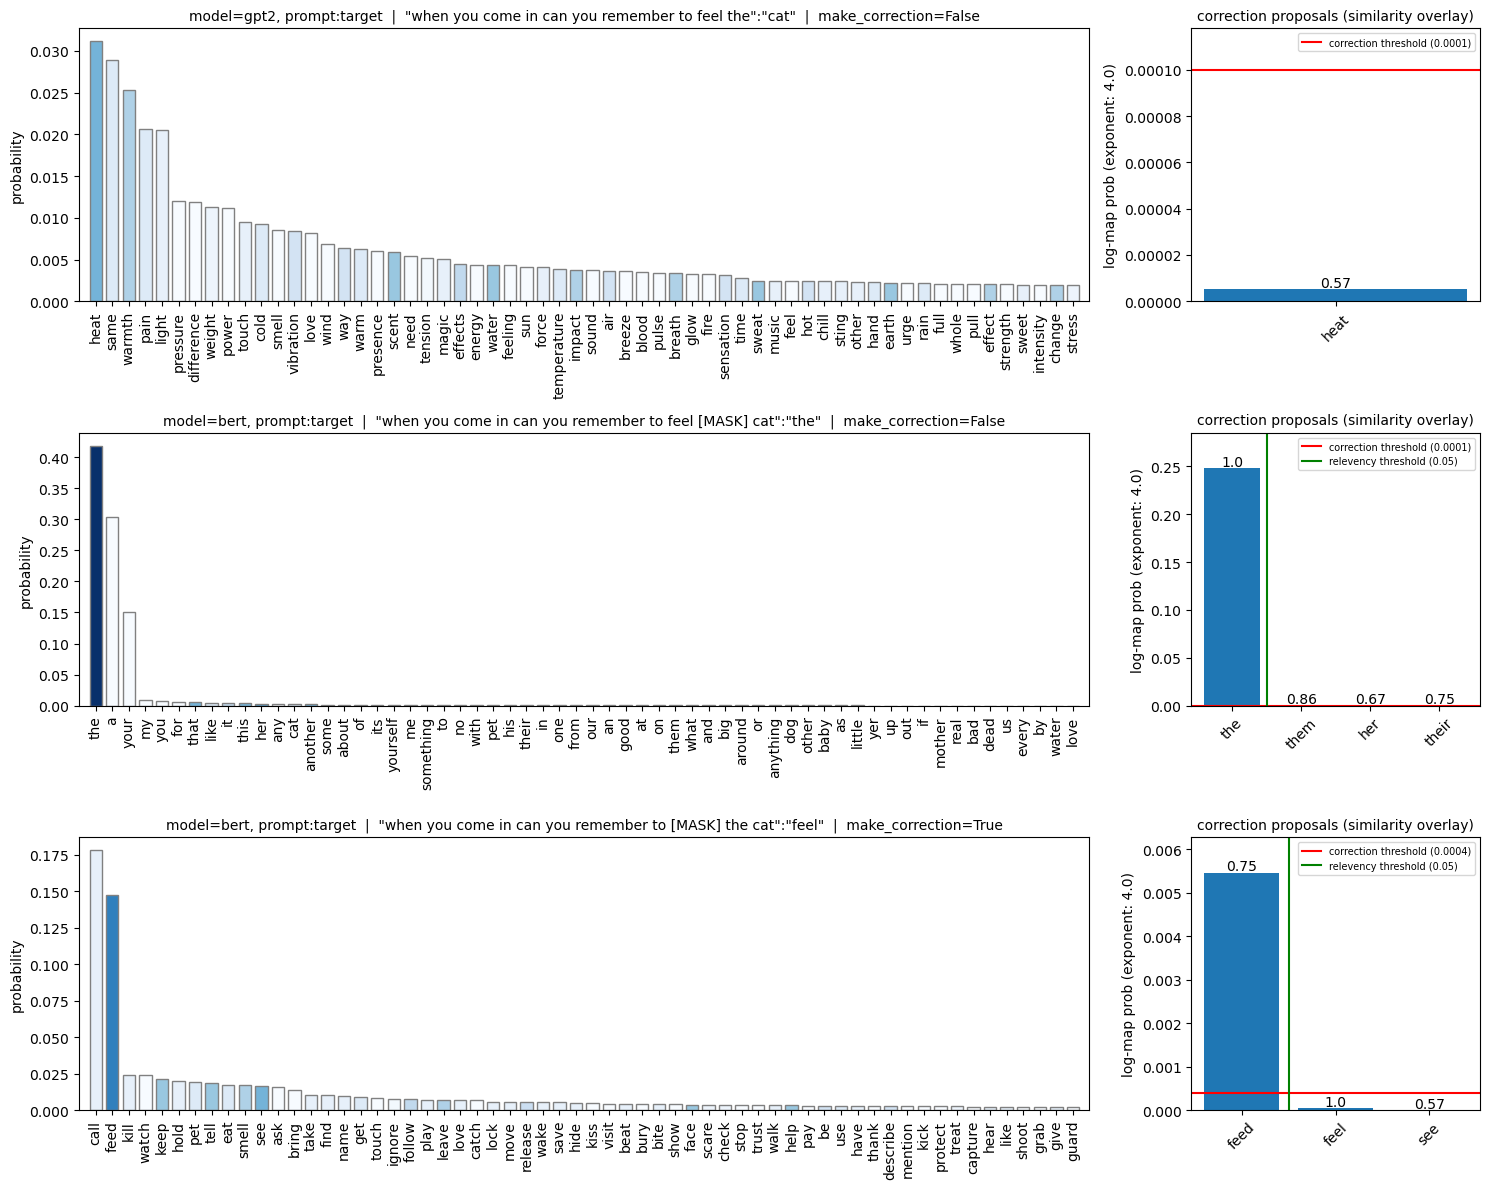

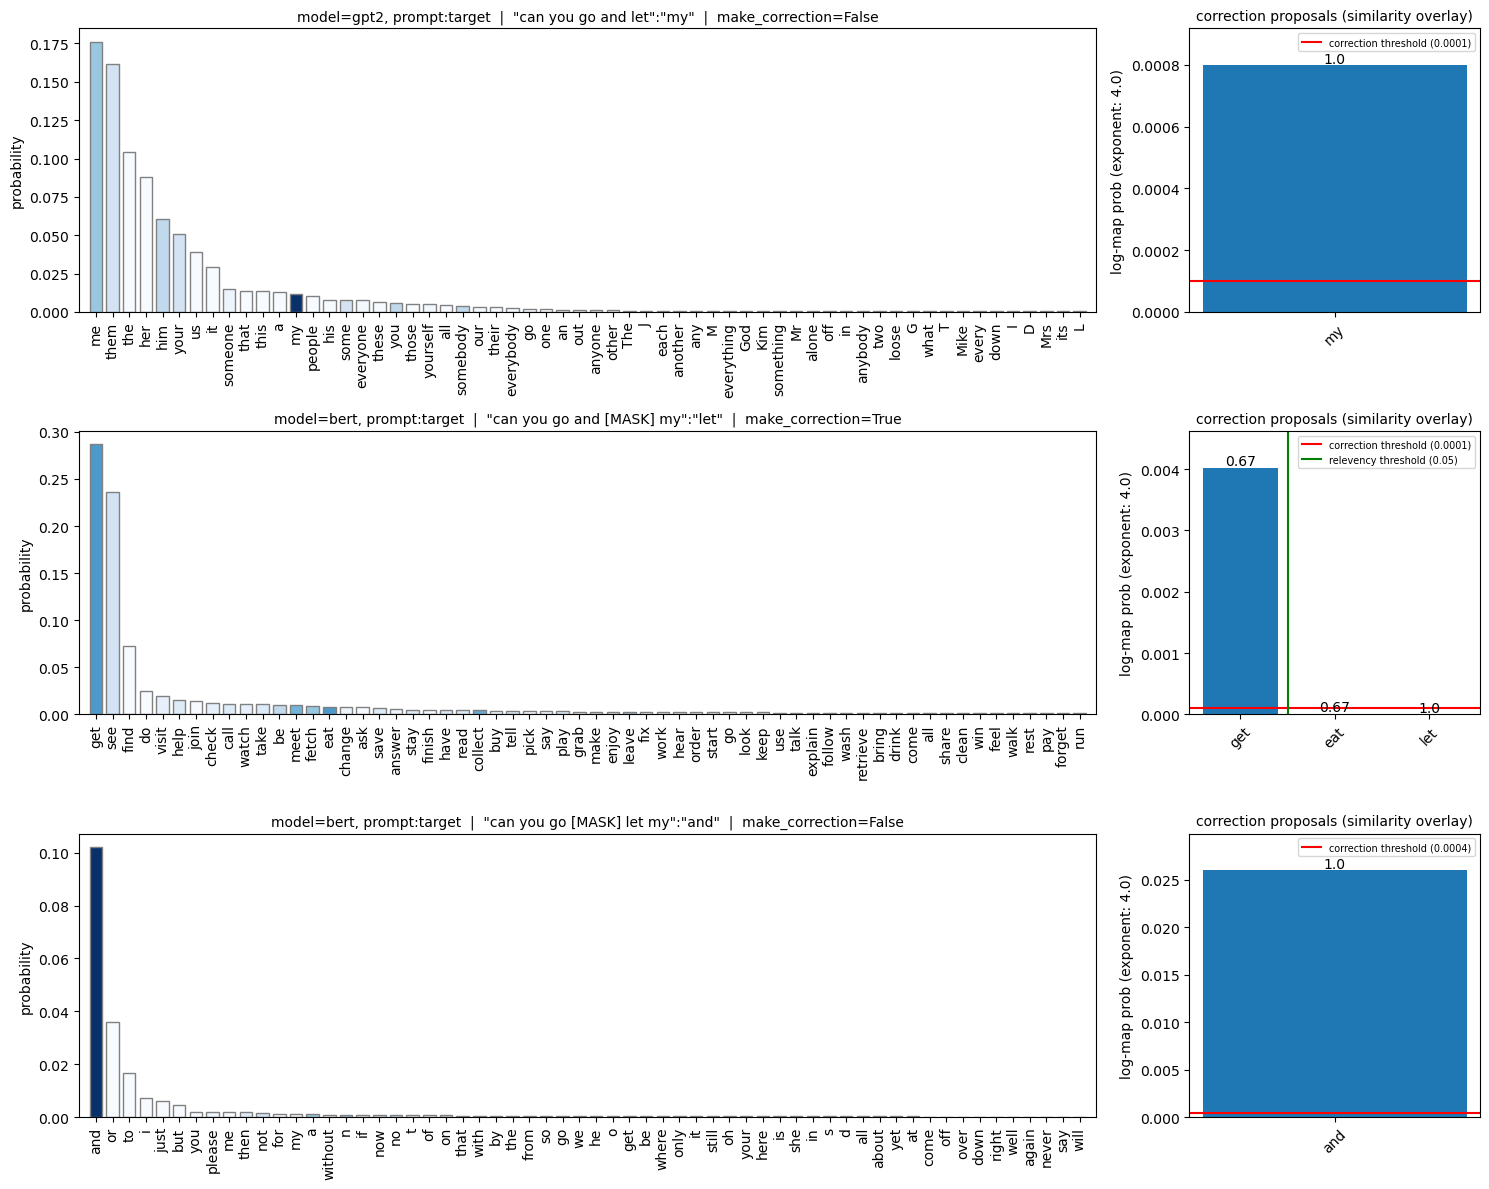

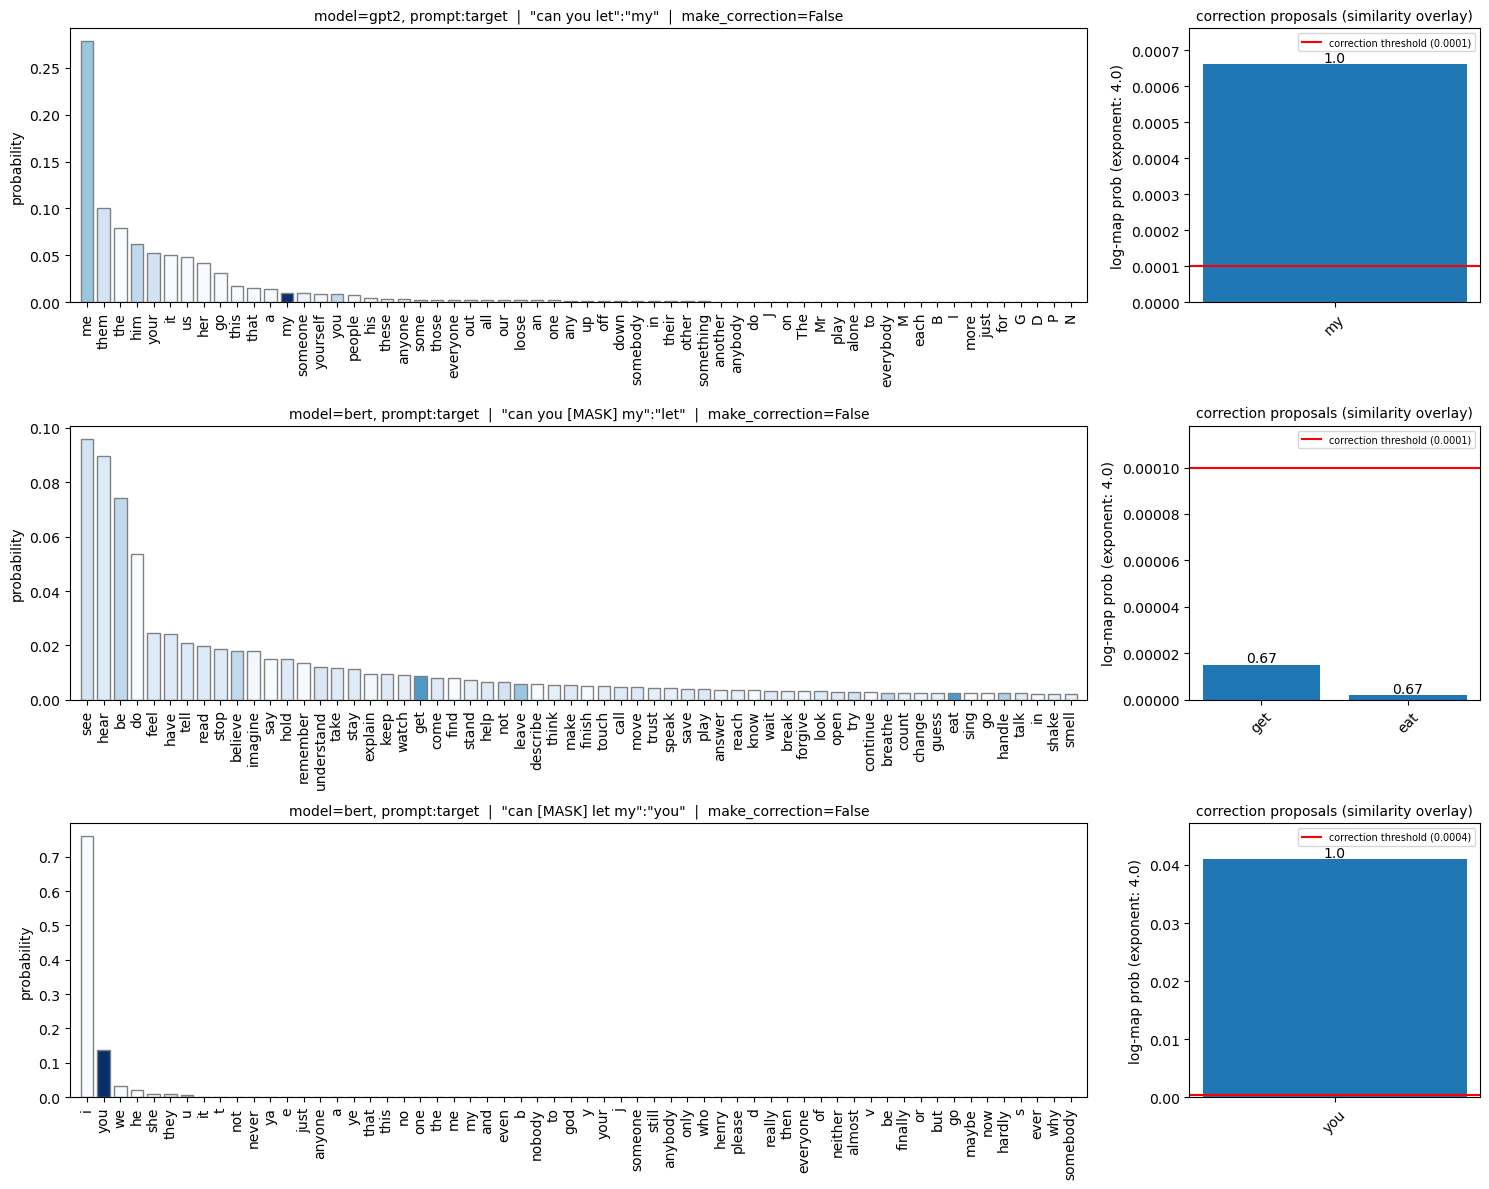

In [6]:
strings = ["when you come in can you remember to feel the cat",
           #"I have to right a note",
           #"This is Eric. He's going to fry to",
           #"do you want any walt or pepper",    
           #"Please don't forget to turn off the store when",
           #"are you going to wear the yellow hat or the bed one",
           #"when do you want to get up to see the fun rise?",
           "can you go and let my",
           "can you let my",
           #"when you come over can you remember to being",
           #"when you come over can you being the soup",
           #"when you come over can you, being the",
           #"I went outside and the wind flew my hat",
           #"After I get out of the shower I usually growl",
           #"Don't step on my wet bug", 
           #"the rally",
           #"can you really climb all the way up that really tall birdling?",
           #"I think you need to pat more attention",
           #"This method isn't really as grate",
           #"Don't step on the wet floor, we're freaching",
           #"Who dat",
           #"When you come over, can you bring the flock we talked about?"
           ]
back_n = 3  # number of words back from end of string, 1 is just last word

log_exp        = 4  # exponent parameter for logarithmic mapping
prob_exp       = 1.6  # raise probability to power in ((prob**power)*log-sim)
consider_top   = 200  # max top model word predictions considered
relevency_t    = 0.05  # threshold defined by portion of top proposition to exclude much smaller scored propositions for correcting
base_t         = 0.0001  # decision threshold for last word: base threshold
threshold_type = "jump-exp"  # function defines decision threshold for word n from end
threshold      = {"constant":    lambda n: base_t,
                  "linear":      lambda n: base_t + (base_t * (n-1)),
                  "exponential": lambda n: base_t * (n**2),
                  "jump-exp":    lambda n: base_t * (max(n-1,1)**2),        # jump thresholds start growing after n=2
                  "jump-lin":    lambda n: base_t + (base_t * max(n-2, 0))
                 }[threshold_type]

plot_data(get_data(strings, back_n, print_times=True))